<a href="https://colab.research.google.com/github/fermiflow/CoulombGas/blob/master/classical_coulomb_gas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import jax
from jax.config import config   
config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import lax, random, jit, vmap
from functools import partial
from jax.scipy.stats import norm
from jax.example_libraries import optimizers
from jax.example_libraries.stax import Dense, Relu, serial
import numpy as np
import matplotlib.pyplot as plt 
from IPython import display

In [20]:
!nvidia-smi
jax.devices()

Tue Aug 16 00:50:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    26W /  70W |  13828MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

[GpuDevice(id=0, process_index=0)]

# Classical Coulomb gas

We'd like to study thermodynamic property of the classical Coulomb gas, whose Hamiltonian reads

$$H= \sum_{i<j} \frac{1}{|\boldsymbol{x}_i - \boldsymbol{x}_j|} + \sum_i  \boldsymbol{x}_i^2 . $$
The second term is a harmonic trapping potential. It makes our story easier (no need to consider periodic bondary condition or Ewald sum for long range interaction.)

The way to go is to minimize the variationial free energy with respect to a variational probability density $p(\boldsymbol{x})$

$$\mathcal{L} = \mathbb{E}_{\boldsymbol{x} \sim p(\boldsymbol{x})} \left [\frac{1}{\beta}\ln p(\boldsymbol{x}) +  H(\boldsymbol{x}) \right] \ge -\frac{1}{\beta} \ln Z, $$ 
where $Z = \int d \boldsymbol{x} e^{-\beta H}$ and $\beta$ is the inverse temperature. The equality holds when $p(\boldsymbol{x}) = e^{-\beta H}/Z$, i.e., we achieve the exact solution. 

First thing first, here is the energy function

In [21]:
def energy_fun(x, n, dim):
    i, j = np.triu_indices(n, k=1)
    r_ee = jnp.linalg.norm((jnp.reshape(x, (n, 1, dim)) - jnp.reshape(x, (1, n, dim)))[i,j], axis=-1)
    v_ee = jnp.sum(1/r_ee)
    return jnp.sum(x**2) + v_ee

## Generative model

### RealNVP

The probablistic model we are going to use is the RealNVP https://arxiv.org/abs/1605.08803, which is one of the simplest but effective normalizing flow method.

In $l$ layer, we divide the inputs into two parts, keep one part and change the other half according to the transformation below:

$$
\begin{aligned}
\mathbf{x}^{l}_< &= \mathbf{x}^{l-1}_< \\
\mathbf{x}^{l}_> &= \mathbf{x}^{l-1}_> e^{s^{l-1}(\mathbf{x}^{l-1}_<)} + t^{l-1}(\mathbf{x}^{l-1}_<),
\end{aligned}
$$

while arbitrary network can be selected as $s$ and $t$, and the jacobian determinant of this transformation simply equals to $e^{s^{l-1}(\mathbf{x}^{l-1}_<)}$.

The inverse transformation is also quite simple

$$
\begin{aligned}
\mathbf{x}^{l-1}_< &= \mathbf{x}^{l}_< \\
\mathbf{x}^{l-1}_> &= (\mathbf{x}^{l}_> - t^{l-1}(\mathbf{x}^{l}_<)) e^{s^{l-1}(\mathbf{x}^{l-1}_<)},
\end{aligned}
$$

Then we reverse the two halves and hand them over to the next layer, ensuring that all inputs will be transformed. Notice that the jacobian determinant of reversing is 1.


In [22]:
def layer(transform):

    def init_fun(rng, input_dim):
        cutoff = input_dim // 2
        perm = jnp.arange(input_dim)[::-1] 
        params, trans_fun = transform(rng, cutoff, 2 * (input_dim - cutoff))

        def direct_fun(params, inputs):
            lower, upper = inputs[:, :cutoff], inputs[:, cutoff:]

            log_weight, bias = trans_fun(params, lower).split(2, axis=1)
            upper = upper * jnp.exp(log_weight) + bias

            outputs = jnp.concatenate([lower, upper], axis=1)
            log_det_jacobian = log_weight.sum(-1)
            return outputs[:,perm], log_det_jacobian

        def inverse_fun(params, inputs):
            inputs = inputs[:, perm]
            lower, upper = inputs[:, :cutoff], inputs[:, cutoff:]

            log_weight, bias = trans_fun(params, lower).split(2, axis=1)
            upper = (upper - bias) * jnp.exp(-log_weight)

            outputs = jnp.concatenate([lower, upper], axis=1)
            log_det_jacobian = log_weight.sum(-1)
            return outputs, log_det_jacobian

        return params, direct_fun, inverse_fun
    
    return init_fun

In [23]:
def RealNVP(transform, n: int):

    def init_fun(rng, input_dim):

        all_params, direct_funs, inverse_funs = [], [], []
        for _ in range(n):
            rng, layer_rng = random.split(rng)
            init_fun = layer(transform)
            param, direct_fun, inverse_fun = init_fun(layer_rng, input_dim)

            all_params.append(param)
            direct_funs.append(direct_fun)
            inverse_funs.append(inverse_fun)

        def feed_forward(params, apply_funs, inputs):
            log_det_jacobians = jnp.zeros(inputs.shape[:1])
            for apply_fun, param in zip(apply_funs, params):
                inputs, log_det_jacobian = apply_fun(param, inputs)
                log_det_jacobians += log_det_jacobian
            return inputs, log_det_jacobians

        def direct_fun(params, inputs):
            return feed_forward(params, direct_funs, inputs)

        def inverse_fun(params, inputs):
            return feed_forward(reversed(params), reversed(inverse_funs), inputs)

        return all_params, direct_fun, inverse_fun

    return init_fun

### Loss function

Gradient of the objective function is

$$\nabla \mathcal{L} = \mathbb{E}_{\boldsymbol{x} \sim p(\boldsymbol{x})} \left[ f (\boldsymbol{x})  \nabla \ln p(\boldsymbol{x}) \right],$$ 
where $f (\boldsymbol{x}) =\frac{1}{\beta}\ln p(\boldsymbol{x}) +  H(\boldsymbol{x})$. This is known as the REINFORCE algorithm, or score function gradient estimator. See https://arxiv.org/abs/1906.10652 for more details. 


In [24]:
def make_reinforce_loss(flow_inverse, n, dim, beta):

    batch_energy = vmap(energy_fun, (0, None, None), 0)

    def loss(params, outputs):
        inputs, log_det_jacobian = flow_inverse(params, outputs)
        log_prob = norm.logpdf(inputs).sum(-1)
        entropy = log_prob - log_det_jacobian
        energy = batch_energy(outputs, n, dim)
        f = entropy/beta +  energy
        f = lax.stop_gradient(f)

        f_mean = jnp.mean(f)
        f_std = jnp.std(f)/jnp.sqrt(f.shape[0])
            
        return jnp.mean((f - f_mean) * entropy), (f_mean, f_std)
    return loss

### Initializing

Now we are ready to initialize a RealNVP network

In [25]:
batchsize = 8192
n = 6
dim = 2 
beta = 10.0
nlayers = 2
rng = random.PRNGKey(42)

def transform(rng, cutoff: int, other: int):
            net_init, net_apply = serial(Dense(16), Relu, Dense(16), Relu, Dense(other))
            in_shape = (-1, cutoff)
            out_shape, net_params = net_init(rng, in_shape)
            return net_params, net_apply

flow_init = RealNVP(transform, nlayers)
    
init_rng, rng = random.split(rng)
params, flow_forward, flow_inverse = flow_init(init_rng, n*dim)

In [26]:
loss = make_reinforce_loss(flow_inverse, n, dim, beta)
value_and_grad = jax.value_and_grad(loss, argnums=0, has_aux=True)

In [27]:
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-2)
opt_state = opt_init(params)

### Training

Here is the training loop. During training we monitor the density and loss histroy. 

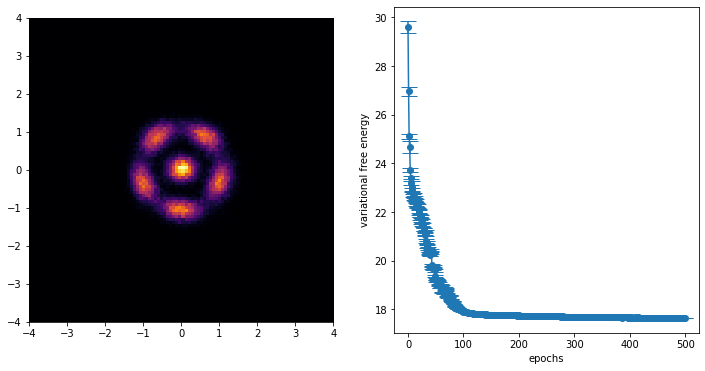

In [28]:
@jit
def step(rng, i, opt_state):
    params = get_params(opt_state)
    
    batch_inputs = jax.random.normal(rng, (batchsize, n*dim)) 
    outputs, _ = flow_forward(params, batch_inputs)

    value, grad = value_and_grad(params, outputs)

    opt_state = opt_update(i, grad, opt_state)
    return value, opt_state, outputs

loss_history = []
for i in range(500):
    step_rng, rng = jax.random.split(rng)
    value, opt_state, x = step(step_rng, i, opt_state)
    _, (f_mean, f_err) = value

    loss_history.append([f_mean, f_err])

    x = jnp.reshape(x, (batchsize*n, dim)) 

    display.clear_output(wait=True)

    fig = plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    H, xedges, yedges = np.histogram2d(x[:, 0], x[:, 1], 
                                       bins=100, 
                                       range=((-4, 4), (-4, 4)),
                        density=True)
    plt.imshow(H, interpolation="nearest", 
               extent=(xedges[0], xedges[-1], yedges[0], yedges[-1]),
               cmap="inferno")

    plt.xlim([-4, 4])
    plt.ylim([-4, 4])

    plt.subplot(1, 2, 2)
    y = np.reshape(np.array(loss_history), (-1, 2))
    plt.errorbar(np.arange(i+1), y[:, 0], yerr=y[:, 1], marker='o', capsize=8)
    plt.xlabel('epochs')
    plt.ylabel('variational free energy')
    plt.pause(0.01)

Let's check the energy of the system after optimization

In [ ]:
sample_realnvp = x.reshape(batchsize, n, dim)
energy_realnvp = vmap(energy_fun, (0, None, None), 0)(sample_realnvp, n, dim)
print(jnp.mean(energy_realnvp), jnp.std(energy_realnvp)/jnp.sqrt(batchsize))

17.387173341031733 0.00289697321442003


Do you see structure emerges from training? 
Yes! It is called [Wigner molecule](https://en.wikipedia.org/wiki/Wigner_crystal). Physicists had already studied [the ground state of Wigner crystals for such small clusters](https://www.sciencedirect.com/science/article/abs/pii/S0749603683710268). the interesting result is that for the case of six electrons, there are five electrons arranged around a single electron at the cneter, which is actually what we get.

A few things to improve from this mininist implementation: 
* It seems the training breaks rotational invariance. But it shouldn't. How to incorporate that into the model design ? 

* How about permutation equivariance $\mathcal{P} \boldsymbol{v}(\boldsymbol{x}) = v(\mathcal{P} \boldsymbol{x})$ ?

* Do you feel it is a bit ackward to integrate the equation twice (one for sampling, one for the likelihood). It is actually easier to implement "reparametrization" gradient estimator. Code it and see why we were not using it here. Again, read https://arxiv.org/abs/1906.10652 for more details 






## MCMC

We can use MCMC to check if we are correct.

In [29]:
@partial(jit, static_argnums=0)
def mcmc(logp_fn, x_init, key, mc_steps, mc_width):
    """
        Markov Chain Monte Carlo sampling algorithm.

    INPUT:
        logp_fn: callable that evaluate log-probability of a batch of configuration x.
            The signature is logp_fn(x), where x has shape (batch, n, dim).
        x_init: initial value of x, with shape (batch, n, dim).
        key: initial PRNG key.
        mc_steps: total number of Monte Carlo steps.
        mc_width: size of the Monte Carlo proposal.

    OUTPUT:
        x: resulting batch samples, with the same shape as `x_init`.
    """
    def step(i, state):
        x, logp, key, num_accepts = state
        key, key_proposal, key_accept = jax.random.split(key, 3)
        
        x_proposal = x + mc_width * jax.random.normal(key_proposal, x.shape)
        logp_proposal = logp_fn(x_proposal)

        ratio = jnp.exp((logp_proposal - logp))
        accept = jax.random.uniform(key_accept, ratio.shape) < ratio

        x_new = jnp.where(accept[:, None, None], x_proposal, x)
        logp_new = jnp.where(accept, logp_proposal, logp)
        num_accepts += accept.sum()
        return x_new, logp_new, key, num_accepts
    
    logp_init = logp_fn(x_init)

    x, logp, key, num_accepts = jax.lax.fori_loop(0, mc_steps, step, (x_init, logp_init, key, 0.))
    batch = x.shape[0]
    accept_rate = num_accepts / (mc_steps * batch)
    return x, accept_rate

In [30]:
@partial(jax.vmap, in_axes=(None, 0, None, None))
def logp(beta, x, n, dim):
    return -beta * energy_fun(x, n, dim)

In [31]:
mc_steps = 100 
mc_width = 0.05

init_rng, rng = random.split(rng)

x = random.normal(init_rng, (batchsize, n, dim))

for _ in range(20):
    mcmc_rng, rng = random.split(rng)
    x, acc = mcmc(lambda x: logp(beta, x, n, dim), x, mcmc_rng, mc_steps, mc_width)
    e = vmap(energy_fun, (0, None, None), 0)(x, n, dim)
    print (acc, jnp.mean(e), jnp.std(e)/jnp.sqrt(batchsize))

0.58614990234375 18.47303547162158 0.013553817156201953
0.620921630859375 17.519845863833876 0.003738762051240855
0.62939208984375 17.40430430918022 0.0025758009487915033
0.630638427734375 17.38942212841285 0.0024867400102478315
0.63100830078125 17.38724308813495 0.002457824322943043
0.630909423828125 17.38852555279054 0.002455893865054881
0.63153564453125 17.388751570831072 0.002483517475873131
0.63089111328125 17.385913331986018 0.0024738192526780546
0.631585693359375 17.38634133128952 0.002505116767542482
0.631322021484375 17.38654925500163 0.0024780787315083906
0.631627197265625 17.38880213243211 0.0024657705489245832
0.63068603515625 17.38632853601986 0.002507079550063235
0.631090087890625 17.392805909396564 0.0025181507930455106
0.63115966796875 17.38774733225801 0.0024617565254753627
0.631026611328125 17.385372555103743 0.002477044814960463
0.63121337890625 17.388031473524812 0.0025261433061877082
0.631463623046875 17.386388947615615 0.0024886751173525475
0.631280517578125 17.38

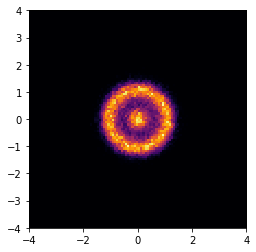

In [32]:
x = jnp.reshape(x, (batchsize*n, dim)) 
#density plot
H, xedges, yedges = np.histogram2d(x[:, 0], x[:, 1], 
                                       bins=100, 
                                       range=((-4, 4), (-4, 4)),
                        density=True)

plt.imshow(H, interpolation="nearest", 
               extent=(xedges[0], xedges[-1], yedges[0], yedges[-1]),
               cmap="inferno")

## Optimizing the ground state energy

With jax, we can also directly optimize the energy funciton, to get the value of the ground state energy, using extremely simple code.

In [33]:
energy_rng, rng = random.split(rng)
x_init = jax.random.normal(energy_rng, (n, dim))

energy_and_grad = jax.value_and_grad(energy_fun)

opt_init, opt_update, get_params = optimizers.adam(step_size=1e-1)
opt_state = opt_init(x_init)

In [34]:
def energy_optimize(rng, i, opt_state):
    x_new = get_params(opt_state)
    energy, grad = energy_and_grad(x_new, n, dim)

    opt_state = opt_update(i, grad, opt_state)
    return energy, opt_state, x_new

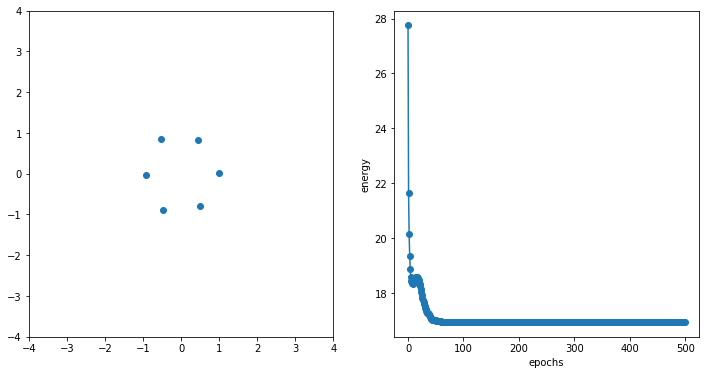

16.94855852962386


In [35]:
energy_history = []
for i in range(500):
    step_rng, rng = jax.random.split(rng)
    value, opt_state, x = energy_optimize(step_rng, i, opt_state)

    energy_history.append([value]) 

    display.clear_output(wait=True)

    fig = plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(x[:, 0], x[:, 1])

    plt.xlim([-4, 4])
    plt.ylim([-4, 4])

    plt.subplot(1, 2, 2)
    y = np.array(energy_history)
    plt.errorbar(np.arange(i+1), y, marker='o', capsize=8)
    plt.xlabel('epochs')
    plt.ylabel('energy')
    plt.pause(0.01)

print(value)

## Benchmark

In [ ]:
plt.

SyntaxError: ignored